# Ideal Diode Example

The simplest way to model a solar cell is as an **ideal diode**, described by the following equation:
$$J(V,T) = J_L+J_0(\exp{\frac{qV}{nkT}}-1)$$
where $k=8.61733\times 10^{-5}$ eV/K is Boltzmann's constant, by convention $J_L$ (the light current) is negative and $J_0$ (the saturation current) is positive but strongly dependent on temperature, a dependence we can approximate as:
$$J_0 \approx B'T^{3/n}\exp{\frac{-E_{g0}}{nkT}}$$
We'll use the silicon zero-temperature bandgap, $E_{g0}=1.2$ eV, meaning we just need to fit for $B'$ in this equation.
$J_L$ is typically directly proportional to light intensity, which we will treat as fixed for this example, leaving us with two parameters to fit for: $B'$ and the ideality factor $n$.

In [1]:
import numpy as np
import sys
import math
import pandas as pd
sys.path.append('../../')
import bayesim.model as bym
import bayesim.param_list as byp
import deepdish as dd
#from jupyterthemes import jtplot
#jtplot.style('default')

## List the parameters
First, we list our fitting parameters.

In [2]:
fp = byp.param_list()
fp.add_fit_param(name='Bp',val_range=[10,1000],spacing='log',length=20,units='arb.')
fp.add_fit_param(name='n',val_range=[1,2],length=20)

We can inspect the `param_list` object and see what kind of information is inside...

In [3]:
#fp.fit_params

Note that there are both `edges` and `vals` computed - the `vals` will be the values at which computations will be done, while `edges` will be the edges of the grid, used in subdivision steps later on.

Finally, we define the measurement conditions. We won't be varying light intensity here, so we only need voltage and temperature.

In [4]:
ec = ['V','T']

In [5]:
m = bym.model(params=fp,ec=ec,output_var='J')

In [6]:
#m.probs.points.head()

## Attach experimental data
This is the next step that needs to be done before adding the model as it will use the experimental conditions we enumerate here to compute simulated outputs. For our "experimental" data here, we'll actually just simulate some ideal diodes so that we can directly see how good the Bayesian approach is at recovering true underlying parameters.

We'll use $n=1.37$ and $B'=258$ as our "true" parameters. (I have no idea what "realistic" values for $B'$ would be...)

In [7]:
def compute_ID(ec,params):
    J_L = -0.03 # treat as fixed for now
    V = ec['V']
    T = ec['T']
    V_th = 8.61733e-5 * T # thermal voltage, kT/q
    n = params['n']
    Bp = params['Bp']
    J0 = Bp*T**(3/n)*math.exp(-1.2/V_th/n)
    return J_L + J0*(math.exp(V/V_th/n)-1)

V = np.arange(0,1.0,0.05)
T = np.arange(150,301,50)
params = {'n':1.37,'Bp':258}

data = []
for t in T:
    for v in V:
        data.append([v,t,compute_ID({'V':v,'T':t},params)])
        
data = pd.DataFrame.from_records(data=data,columns=['V','T','J'])
#data.to_hdf('obs_data.h5','data',format='table',append=False)
#dd.io.save('obs_data.h5',data)

In [8]:
m.attach_observations(fpath='obs_data.h5')

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
leg = []
for i in range(len(T)):
    curve = data.iloc[len(V)*i:len(V)*(i+1)]
    plt.plot(curve['V'],curve['J'])
    leg.append(curve['T'].iloc[0])
plt.ylim([-0.05,0.1])
plt.legend([str(t) for t in leg])
plt.xlabel('Voltage [V]')
plt.ylabel('Current')

In [ ]:
m.obs_data.head()

## Attach model
Now we add the function that gives the modeled data - in this case, the `compute_ID` function we just defined above.

In [9]:
#m.attach_model(mode='function',func_name=compute_ID)
m.attach_model(fpath='model_data.h5')

That's it! When that function is called, `bayesim` also generates the full table of modeled data at all experimental conditions in the observed data we attached before. Check it out:

In [ ]:
#m.model_data.head(10)

## Drop that Bayes!

In [14]:
m.run()

time to subdivide!


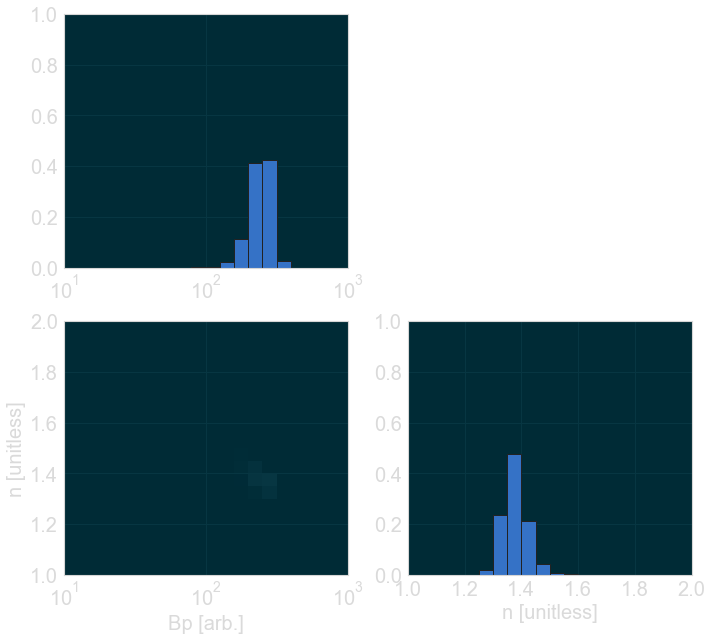

In [11]:
m.probs.visualize()

In [ ]:
m.probs.most_probable(40)

In [ ]:
m.probs.subdivide(0.001)

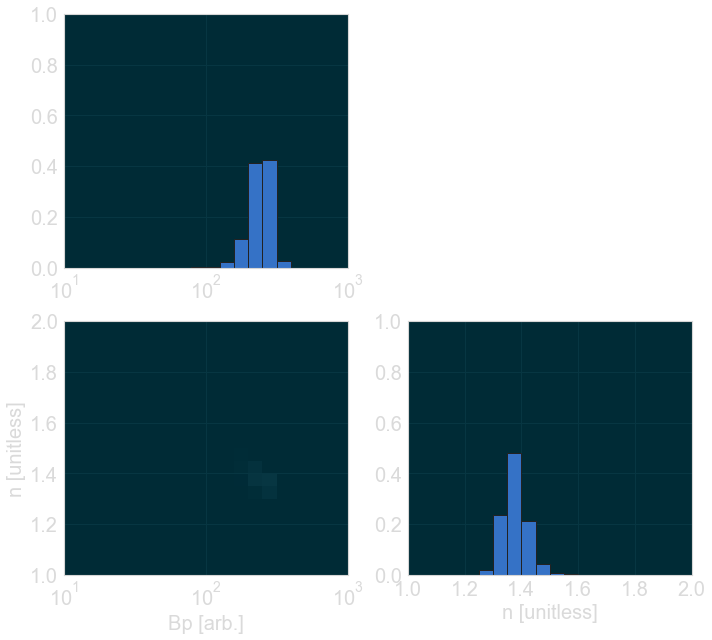

In [15]:
m.probs.visualize()

In [12]:
m.save_state()

In [13]:
m = bym.model(state_file='bayesim_state.h5')